# Utils

In [181]:
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import scipy
from copy import deepcopy
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import torch
from torch import nn
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Lasso

In [200]:
from copy import deepcopy
import pickle
import os

from sklearn.model_selection import KFold
import numpy as np
from tqdm.notebook import tqdm


def reg_stacking_fit(base_models, meta_model, model_names, X, y, folder_path, nfolds=5):
    meta_X = np.zeros((len(X), len(base_models)))
    meta_y = np.zeros(len(X))
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=RANDOM_STATE)
    i = 0
    for (train_index, test_index) in tqdm(kf.split(X)):
        train_X, train_y = X.iloc[train_index], y.iloc[train_index]
        test_X, test_y = X.iloc[test_index], y.iloc[test_index]

        for idx, model in enumerate(base_models):
            fold_model = deepcopy(model)
            
            if isinstance(fold_model, RandomForestRegressor):
                fold_model.fit(train_X[base_features + generated_features], train_y)
                preds = fold_model.predict(test_X[base_features + generated_features])
            else:
                fold_model.fit(train_X, train_y)
                preds = fold_model.predict(test_X)
            meta_X[test_index, idx] = preds
            with open(
                os.path.join(folder_path, f"{model_names[idx]}_{i}.pickle"), "wb"
            ) as fin:
                pickle.dump(fold_model, fin)

        meta_y[test_index] = test_y.values.flatten()
        i += 1
    meta_model.fit(meta_X, meta_y)
    with open(os.path.join(folder_path, f"meta_{model_names[-1]}.pickle"), "wb") as fin:
        pickle.dump(meta_model, fin)


def reg_stacking_predict(model_names, X, folder_path, nfolds=5):
    meta_X = np.zeros((len(X), len(model_names) - 1))
    for idx, _ in enumerate(model_names[:-1]):
        preds = np.zeros(len(X))
        for i in range(nfolds):
            with open(
                os.path.join(folder_path, f"{model_names[idx]}_{i}.pickle"), "rb"
            ) as fout:
                fold_model = pickle.load(fout)
                
            if isinstance(fold_model, RandomForestRegressor):
                preds += fold_model.predict(X[base_features + generated_features])
                #print(fold_model.predict(X[base_features + generated_features]))
            else:
                preds += fold_model.predict(X[base_features + generated_features + generated_complex_features])
                #print(X[base_features + generated_features + generated_complex_features])
        preds /= nfolds
        meta_X[:, idx] = preds
    with open(
        os.path.join(folder_path, f"meta_{model_names[-1]}.pickle"), "rb"
    ) as fout:
        meta_model = pickle.load(fout)
    meta_preds = meta_model.predict(meta_X)
    return meta_preds

In [183]:
import matplotlib.pyplot as plt
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [184]:
def cross_val(
    model,
    data,
    labels,
    n_splits,
    random_state,
    shuffle = True):
    
    
    kfold = KFold(n_splits=5,
                  shuffle=True,
                  random_state=RANDOM_STATE)
    scores = []
    models = []
    for fold, (train_ids, test_ids) in enumerate(kfold.split(data)):
        fold_model = deepcopy(model)
        fold_model.fit(data.iloc[train_ids],
                       labels.iloc[train_ids],
                       eval_set = (data.iloc[test_ids],labels.iloc[test_ids]), verbose = 0)
        r2_train = r2_score(labels.iloc[train_ids], fold_model.predict(data.iloc[train_ids]))
        r2_test = r2_score(labels.iloc[test_ids], fold_model.predict(data.iloc[test_ids]))
        models.append(fold_model)
        scores.append(r2_test)
       # print(f'Fold: {fold} Train_metric: {r2_train} Eval_metric: {r2_test}')
    return np.array(scores), models

# EDA

In [5]:
RANDOM_STATE = 52


In [6]:
data = pd.read_csv('mars-train-regr.csv')

In [7]:
cat_features = ['Количество импульсов']

In [8]:
radian_features = ['У.М.', 'Азимут']
generated_features = []
generated_complex_features = []
target_feature = ['Доля сигнала в ВП']
drop_features = ['№ испытания', 'Фаза Hor', 'Фаза Ver']

In [9]:
base_features = data.drop(columns = drop_features + target_feature).columns.tolist()

In [10]:
for radian_feature in radian_features:
    if 'Фаза' in radian_feature:
        data[f'sin {radian_feature}'] = np.sin(data[radian_feature])
        data[f'cos {radian_feature}'] = np.cos(data[radian_feature])
    else:
        data[f'sin {radian_feature}'] = np.sin((np.pi / 180) * data[radian_feature])
        data[f'cos {radian_feature}'] = np.cos((np.pi / 180) * data[radian_feature])
    generated_features.append(f'sin {radian_feature}')
    generated_features.append(f'cos {radian_feature}')

In [11]:
for radian_feature in radian_features:
    for trig_func in ['sin', 'cos']:
        data[f'fft {trig_func} {radian_feature}'] = scipy.fft.fft(np.array(data[f'{trig_func} {radian_feature}'].tolist()))
        generated_complex_features.append(f'fft {trig_func} {radian_feature}')
        data[f'abs fft {trig_func} {radian_feature}'] = np.abs(data[f'fft {trig_func} {radian_feature}'])
        generated_features.append(f'abs fft {trig_func} {radian_feature}')

In [12]:
data['Модуль импульса'] = data['Модуль сигнала'] / data['Количество импульсов']
generated_features.append('Модуль импульса')

In [13]:
data['Проекция дальности на нормаль машины'] = data['Дальность (м)'] * data['sin У.М.']
data['Проекция дальности на нормаль камеры'] = data['Дальность (м)'] * data['cos У.М.']
generated_features.extend(['Проекция дальности на нормаль машины', 'Проекция дальности на нормаль камеры'])

In [14]:
data['Скорость (хуйня)'] = data['Дальность (м)'] / data['Секунда']
generated_features.append('Скорость (хуйня)')

In [15]:
data['Фаза'] = data['Фаза Ver'] + data['Фаза Hor']

In [16]:
data['z'] = data['Модуль импульса'] * np.cos(data['Фаза']) + (data['Модуль импульса'] * np.sin(data['Фаза'])).apply(lambda x: np.complex(0,x))

In [17]:
data['P'] = np.abs(data['z']) ** 2

In [18]:
data['RCS'] = (data['Фаза'] ** 2 + (data['Дальность (м)'] ** 2) * data['Уровень шума']) / data['P']

In [19]:
data['Уровень интенсивности шума'] = 10 ** (data['Уровень шума'] / 10)# * 10**12

In [20]:
generated_features.extend(['Фаза', 'P', 'RCS', 'Уровень интенсивности шума'])

In [21]:
generated_complex_features.append('z')

In [22]:
max_value = data['Уровень интенсивности шума'].max()

In [23]:
data['Уровень интенсивности шума'] /= max_value

In [24]:
max_value

3.5235150199355466e+126

# Model training with new features

## Hyperopt

In [49]:
def hyperopt_objective(params, train_data, train_labels):
    model = CatBoostRegressor(**params, eval_metric = 'R2', 
                       use_best_model = True, 
                       random_state = RANDOM_STATE)
    
    
    score = cross_val(model, train_data, train_labels, 5, RANDOM_STATE, shuffle = True)[0]

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [50]:
params = {
        "learning_rate": hp.uniform("learning_rate", 0.001, 0.1),
        "max_depth": hp.randint("max_depth", 1, 7),
        "boosting_type": hp.choice("boosting_type", ["Ordered", "Plain"]),
        "iterations": hp.randint('iterations', 1000, 10000)
    }

In [83]:
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(hyperopt_objective, train_data = data[base_features + generated_features + generated_complex_features], train_labels = data[target_feature]),
          # пространство поиска гиперпараметров  
            space=params,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=100,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.default_rng(RANDOM_STATE),
          # progressbar
            show_progressbar=True
        )

  1%|█                                                                                                     | 1/100 [00:46<1:16:15, 46.22s/trial, best loss: -0.5707455064787654]



KeyboardInterrupt



In [821]:
best['boosting_type'] = ["Ordered", "Plain"][0]

## CatBoost with new features

In [153]:
train_data, eval_data, train_labels, eval_labels = train_test_split(data[base_features + generated_features + generated_complex_features],  #drop_features),
    data[target_feature], test_size = 0.3, random_state = RANDOM_STATE, shuffle = True)

In [84]:
cb = CatBoostRegressor(eval_metric = 'R2', 
                       use_best_model = True, 
                       random_state = RANDOM_STATE)

In [86]:
cb.fit(
    train_data,
    train_labels,
    #cat_features = cat_features,
    eval_set = (eval_data,eval_labels), 
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077633
0:	learn: 0.0160192	test: 0.0140328	best: 0.0140328 (0)	total: 62.8ms	remaining: 1m 2s
1:	learn: 0.0278438	test: 0.0249945	best: 0.0249945 (1)	total: 64.8ms	remaining: 32.3s
2:	learn: 0.0414413	test: 0.0375919	best: 0.0375919 (2)	total: 66.7ms	remaining: 22.2s
3:	learn: 0.0518831	test: 0.0470109	best: 0.0470109 (3)	total: 68.5ms	remaining: 17s
4:	learn: 0.0592662	test: 0.0537049	best: 0.0537049 (4)	total: 70.2ms	remaining: 14s
5:	learn: 0.0690034	test: 0.0622289	best: 0.0622289 (5)	total: 72.6ms	remaining: 12s
6:	learn: 0.0805168	test: 0.0730458	best: 0.0730458 (6)	total: 74.5ms	remaining: 10.6s
7:	learn: 0.0871422	test: 0.0797945	best: 0.0797945 (7)	total: 76.3ms	remaining: 9.47s
8:	learn: 0.0935289	test: 0.0860162	best: 0.0860162 (8)	total: 78.2ms	remaining: 8.61s
9:	learn: 0.0983396	test: 0.0902682	best: 0.0902682 (9)	total: 80ms	remaining: 7.92s
10:	learn: 0.1046525	test: 0.0964772	best: 0.0964772 (10)	total: 82.6ms	remaining: 7.43s
11:	learn: 0.112617

In [86]:
best_cb = CatBoostRegressor(iterations = 8500,
    #**best,
 loss_function =  'RMSE',
    random_state = RANDOM_STATE,
 eval_metric ='R2' )

In [87]:
base_features

['Модуль сигнала',
 'Тип_измерения',
 'Количество импульсов',
 'Уровень шума',
 'Азимут',
 'У.М.',
 'Секунда',
 'Дальность (м)']

In [44]:
data['Доля сигнала в ВП'].describe()

count    20965.000000
mean         0.638981
std          0.270730
min          0.000307
25%          0.448628
50%          0.695270
75%          0.872931
max          0.999980
Name: Доля сигнала в ВП, dtype: float64

In [88]:
best_cb.fit(data[base_features + generated_features + generated_complex_features],
    data[target_feature],
    plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.011624
0:	learn: 0.0025245	total: 3.33ms	remaining: 28.3s
1:	learn: 0.0046587	total: 5.95ms	remaining: 25.3s
2:	learn: 0.0069041	total: 8.47ms	remaining: 24s
3:	learn: 0.0089446	total: 11.2ms	remaining: 23.9s
4:	learn: 0.0111417	total: 13.9ms	remaining: 23.6s
5:	learn: 0.0133530	total: 16.4ms	remaining: 23.3s
6:	learn: 0.0150213	total: 18.7ms	remaining: 22.6s
7:	learn: 0.0171075	total: 20.9ms	remaining: 22.2s
8:	learn: 0.0189801	total: 23.4ms	remaining: 22.1s
9:	learn: 0.0212580	total: 25.7ms	remaining: 21.8s
10:	learn: 0.0233515	total: 28.1ms	remaining: 21.6s
11:	learn: 0.0251176	total: 30.7ms	remaining: 21.7s
12:	learn: 0.0269820	total: 33.1ms	remaining: 21.6s
13:	learn: 0.0291081	total: 35.4ms	remaining: 21.5s
14:	learn: 0.0308865	total: 37.6ms	remaining: 21.3s
15:	learn: 0.0328037	total: 40ms	remaining: 21.2s
16:	learn: 0.0345498	total: 42.4ms	remaining: 21.2s
17:	learn: 0.0363209	total: 45.2ms	remaining: 21.3s
18:	learn: 0.0378744	total: 47.7ms	remaining: 21

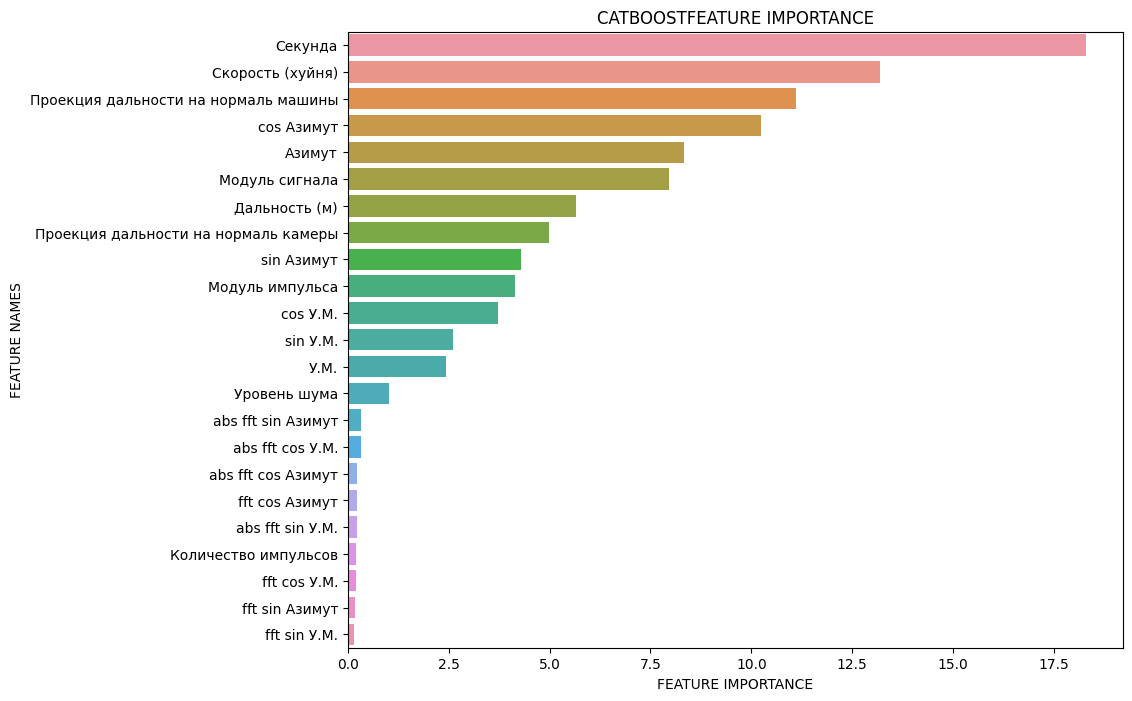

In [876]:
plot_feature_importance(best_cb.get_feature_importance(),data[base_features + generated_features + generated_complex_features].columns,'CATBOOST')

In [89]:
r2_score(eval_labels, cb.predict(eval_data)) * 70

NameError: name 'eval_labels' is not defined

## CatBoost with base features

In [688]:
base_features_cb = CatBoostRegressor(eval_metric = 'R2', 
                        loss_function = 'RMSE',
                       use_best_model = True, 
                       random_state = RANDOM_STATE)

In [690]:
base_features_cb.fit(
    train_data[base_features],
    train_label,
    #cat_features = cat_features,
    eval_set = (eval_data[base_features],eval_labels), 
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077633
0:	learn: 0.0143331	test: 0.0130350	best: 0.0130350 (0)	total: 2.96ms	remaining: 2.96s
1:	learn: 0.0262875	test: 0.0241573	best: 0.0241573 (1)	total: 4.97ms	remaining: 2.48s
2:	learn: 0.0393838	test: 0.0364901	best: 0.0364901 (2)	total: 6.88ms	remaining: 2.29s
3:	learn: 0.0496618	test: 0.0452042	best: 0.0452042 (3)	total: 8.94ms	remaining: 2.22s
4:	learn: 0.0595520	test: 0.0540427	best: 0.0540427 (4)	total: 11.4ms	remaining: 2.26s
5:	learn: 0.0671370	test: 0.0608580	best: 0.0608580 (5)	total: 13.4ms	remaining: 2.22s
6:	learn: 0.0728584	test: 0.0662306	best: 0.0662306 (6)	total: 16ms	remaining: 2.27s
7:	learn: 0.0769884	test: 0.0698248	best: 0.0698248 (7)	total: 18.4ms	remaining: 2.28s
8:	learn: 0.0853148	test: 0.0777196	best: 0.0777196 (8)	total: 20.4ms	remaining: 2.25s
9:	learn: 0.0942753	test: 0.0857101	best: 0.0857101 (9)	total: 22.5ms	remaining: 2.23s
10:	learn: 0.1008177	test: 0.0910903	best: 0.0910903 (10)	total: 24.4ms	remaining: 2.19s
11:	learn: 0.

In [694]:
base_features_best_cb = CatBoostRegressor(#cat_features = cat_features,
    iterations = n_estimators, learning_rate = cb.learning_rate_,
 loss_function =  'RMSE',
 #use_best_model = True,
    #cat_features = ['Количество импульсов'],
    random_state = RANDOM_STATE,
 eval_metric ='R2' )

In [695]:
base_features_best_cb.fit(data[base_features],
    data[target_feature],
    plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0137675	total: 3.46ms	remaining: 3.45s
1:	learn: 0.0282467	total: 5.99ms	remaining: 2.98s
2:	learn: 0.0403303	total: 8.38ms	remaining: 2.78s
3:	learn: 0.0507538	total: 10.5ms	remaining: 2.6s
4:	learn: 0.0615294	total: 13.3ms	remaining: 2.64s
5:	learn: 0.0696802	total: 15.1ms	remaining: 2.5s
6:	learn: 0.0765292	total: 17.2ms	remaining: 2.43s
7:	learn: 0.0810816	total: 19.1ms	remaining: 2.36s
8:	learn: 0.0898498	total: 20.8ms	remaining: 2.29s
9:	learn: 0.0978172	total: 22.5ms	remaining: 2.22s
10:	learn: 0.1026065	total: 24.4ms	remaining: 2.19s
11:	learn: 0.1074273	total: 26.1ms	remaining: 2.14s
12:	learn: 0.1107301	total: 27.8ms	remaining: 2.1s
13:	learn: 0.1149780	total: 29.5ms	remaining: 2.08s
14:	learn: 0.1202842	total: 31.1ms	remaining: 2.04s
15:	learn: 0.1252524	total: 32.8ms	remaining: 2.02s
16:	learn: 0.1294809	total: 34.8ms	remaining: 2s
17:	learn: 0.1330609	total: 36.6ms	remaining: 1.99s
18:	learn: 0.1380612	total: 38.3ms	remaining: 1.98s
19:	learn: 0.1417061	total: 

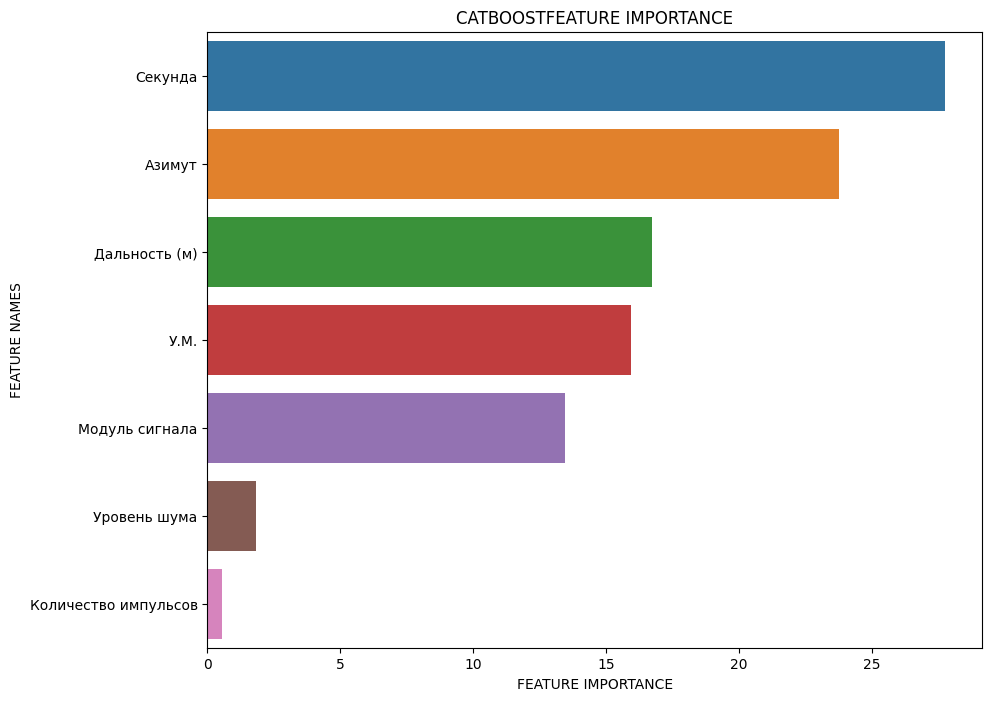

In [699]:
plot_feature_importance(base_features_best_cb.get_feature_importance(),data[base_features].columns,'CATBOOST')

In [726]:
r2_score(eval_labels, base_features_cb.predict(eval_data[base_features])) * 70

43.24627725150219

In [700]:
r2_score(eval_labels, (cb.predict(eval_data) + base_features_cb.predict(eval_data[base_features])) / 2) * 70

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


43.29310295745142

## RandomForestRegressor with new_features except complex

In [133]:
rf = RandomForestRegressor(verbose = True)

In [135]:
rf.fit(train_data[base_features + generated_features], train_label)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.1s


RandomForestRegressor(verbose=True)

In [136]:
r2_score(eval_labels, rf.predict(eval_data[base_features + generated_features])) * 70

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


49.19665618582582

In [138]:
best_rf = RandomForestRegressor(verbose = True)
best_rf.fit(data[base_features + generated_features], data[target_feature])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.5s


RandomForestRegressor(verbose=True)

In [707]:
r2_score(eval_labels, (rf.predict(eval_data[base_features + generated_features]) + cb.predict(eval_data) + base_features_cb.predict(eval_data[base_features])) / 3) * 70

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


46.664962873354945

## Stacking

In [195]:
rf_base_model = RandomForestRegressor()
cb_symmetric =CatBoostRegressor(
    iterations = 8000,
    learning_rate = 0.02,
    boosting_type = 'Ordered',
    eval_metric = 'R2', 
    #use_best_model = True, 
    random_state = RANDOM_STATE,
    verbose = False
)

In [196]:
cb_depthwise = CatBoostRegressor(
     iterations = 8000,
    #learning_rate = 0.01,
    eval_metric = 'R2', 
    #use_best_model = True, 
    random_state = RANDOM_STATE,
    grow_policy = 'Depthwise',
    verbose = False
)

In [197]:
meta_model = Lasso()

In [198]:
reg_stacking_fit(
    base_models = [rf_base_model, cb_symmetric, cb_depthwise],
    meta_model = meta_model, 
    model_names = ['random_forest', 'cb_symmetric', 'cb_depthwise', 'lasso'], 
    X = train_data[base_features + generated_features + generated_complex_features],
    y = train_labels,
    folder_path = 'meta_model',
    nfolds=5
)

0it [00:00, ?it/s]

In [201]:
reg_stacking_predict(model_names = ['random_forest', 'cb_symmetric', 'cb_depthwise', 'lasso'],
                     X = eval_data[base_features + generated_features + generated_complex_features],
                     folder_path = 'meta_model',
                        nfolds=5)

array([0.63965015, 0.63965015, 0.63965015, ..., 0.63965015, 0.63965015,
       0.63965015])

In [202]:
r2_score(eval_labels, reg_stacking_predict(model_names = ['random_forest', 'cb_symmetric', 'cb_depthwise', 'lasso'],
                     X = eval_data[base_features + generated_features + generated_complex_features],
                     folder_path = 'meta_model',
                        nfolds=5))

-6.759915490950341e-05

# Submission

In [105]:
test_data = pd.read_csv('mars-public_test-regr.csv')

In [91]:
for radian_feature in radian_features:
    if 'Фаза' in radian_feature:
        test_data[f'sin {radian_feature}'] = np.sin(test_data[radian_feature])
        test_data[f'cos {radian_feature}'] = np.cos(test_data[radian_feature])
    else:
        test_data[f'sin {radian_feature}'] = np.sin((np.pi / 180) * test_data[radian_feature])
        test_data[f'cos {radian_feature}'] = np.cos((np.pi / 180) * test_data[radian_feature])

In [92]:
for radian_feature in radian_features:
    for trig_func in ['sin', 'cos']:
        test_data[f'fft {trig_func} {radian_feature}'] = scipy.fft.fft(np.array(test_data[f'{trig_func} {radian_feature}'].tolist()))
        test_data[f'abs fft {trig_func} {radian_feature}'] = np.abs(test_data[f'fft {trig_func} {radian_feature}'])

In [93]:
test_data['Модуль импульса'] = test_data['Модуль сигнала'] / test_data['Количество импульсов']

In [94]:
test_data['Проекция дальности на нормаль машины'] = test_data['Дальность (м)'] * test_data['sin У.М.']
test_data['Проекция дальности на нормаль камеры'] = test_data['Дальность (м)'] * test_data['cos У.М.']

In [95]:
test_data['Скорость (хуйня)'] = test_data['Дальность (м)'] / test_data['Секунда']

In [96]:
test_data['Фаза'] = test_data['Фаза Ver'] + test_data['Фаза Hor']

In [97]:
test_data['z'] = test_data['Модуль импульса'] * np.cos(test_data['Фаза']) + (test_data['Модуль импульса'] * np.sin(test_data['Фаза'])).apply(lambda x: np.complex(0,x))

In [98]:
test_data['P'] = np.abs(test_data['z']) ** 2

In [99]:
test_data['RCS'] = (test_data['Фаза'] ** 2 + (test_data['Дальность (м)'] ** 2) * test_data['Уровень шума']) / test_data['P']

In [127]:
test_data['Уровень интенсивности шума'] = 10 ** (test_data['Уровень шума'] / 10)# * 10**12

In [128]:
test_data['Уровень интенсивности шума'] /= max_value

In [105]:
ordered_columns = data[base_features + generated_features + generated_complex_features].columns

ensemble predict

In [717]:
preds = rf.predict(test_data[oredered_columns]) +  cb.predict(test_data[eval_data.columns]) + base_features_cb.predict(test_data[base_features])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [719]:
test_data['Доля сигнала в ВП'] = preds / 3

In [139]:
preds = best_rf.predict(test_data[base_features + generated_features])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [140]:
test_data['Доля сигнала в ВП'] = preds

In [142]:
test_data[base_features + drop_features + target_feature].to_csv('first_submission.csv', index = False)

In [141]:
test_data[base_features + drop_features + target_feature]

,Модуль сигнала,Тип_измерения,Количество импульсов,Уровень шума,Азимут,У.М.,Секунда,Дальность (м),№ испытания,Фаза Hor,Фаза Ver,Доля сигнала в ВП
0,2228.58,1,2,95.340461,8.576654,12.988322,1.874687e+03,2789.785685,1,-1.296037,-0.823444,0.476813
1,1886.45,1,2,96.199134,26.927104,13.798552,1.874785e+03,2734.624786,1,1.570796,1.570796,0.730667
2,2015.85,1,2,87.818645,8.393800,12.966248,1.874883e+03,2785.661124,1,1.570796,1.570796,0.599111
3,11495.21,1,2,71.244075,28.437188,13.875287,1.874953e+03,2706.620650,1,1.570796,1.570796,0.627955
4,1595.66,1,2,82.509944,8.252281,12.861609,1.875092e+03,2781.097562,1,1.570796,1.570796,0.515193
...,...,...,...,...,...,...,...,...,...,...,...,...
4485,1127.39,4,1,80.449525,-39.347686,68.876576,1.476153e+06,990.507201,3,-2.532464,-2.161597,0.809121
4486,1015.29,4,1,85.928771,-39.362483,68.878026,1.476153e+06,990.507201,3,1.022957,1.786013,0.731301
4487,1066.67,4,1,80.725173,-39.377443,68.879453,1.476153e+06,990.496991,3,-1.177634,-0.582136,0.721379
4488,1003.16,4,1,80.661715,-39.392247,68.880902,1.476153e+06,990.486782,3,2.069521,2.681160,0.758295


In [605]:
cross_val(
    cb,
    data.drop(columns = target_feature + drop_features),
    data[target_feature],
    n_splits = 5,
    random_state = RANDOM_STATE
)

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.079279
0:	learn: 0.0159326	test: 0.0144216	best: 0.0144216 (0)	total: 2.35ms	remaining: 2.35s
1:	learn: 0.0303346	test: 0.0273089	best: 0.0273089 (1)	total: 4.66ms	remaining: 2.33s
2:	learn: 0.0425166	test: 0.0401719	best: 0.0401719 (2)	total: 6.79ms	remaining: 2.26s
3:	learn: 0.0538603	test: 0.0517016	best: 0.0517016 (3)	total: 8.93ms	remaining: 2.22s
4:	learn: 0.0643286	test: 0.0615559	best: 0.0615559 (4)	total: 11.2ms	remaining: 2.22s
5:	learn: 0.0722313	test: 0.0688489	best: 0.0688489 (5)	total: 13.3ms	remaining: 2.2s
6:	learn: 0.0777551	test: 0.0737184	best: 0.0737184 (6)	total: 15.7ms	remaining: 2.23s
7:	learn: 0.0859519	test: 0.0820956	best: 0.0820956 (7)	total: 17.8ms	remaining: 2.21s
8:	learn: 0.0908503	test: 0.0868115	best: 0.0868115 (8)	total: 19.7ms	remaining: 2.17s
9:	learn: 0.0990391	test: 0.0946388	best: 0.0946388 (9)	total: 21.8ms	remaining: 2.16s
10:	learn: 0.1032987	test: 0.0988609	best: 0.0988609 (10)	total: 23.8ms	remaining: 2.14s
11:	learn: 0

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Fold: 0 Train_metric: 0.7686669184270634 Eval_metric: 0.6276026656944123
Learning rate set to 0.079279
0:	learn: 0.0171108	test: 0.0135571	best: 0.0135571 (0)	total: 2.17ms	remaining: 2.16s
1:	learn: 0.0301001	test: 0.0249816	best: 0.0249816 (1)	total: 4.25ms	remaining: 2.12s
2:	learn: 0.0427008	test: 0.0350802	best: 0.0350802 (2)	total: 6.3ms	remaining: 2.1s
3:	learn: 0.0547552	test: 0.0457938	best: 0.0457938 (3)	total: 8.8ms	remaining: 2.19s
4:	learn: 0.0669324	test: 0.0564896	best: 0.0564896 (4)	total: 11ms	remaining: 2.19s
5:	learn: 0.0762129	test: 0.0637235	best: 0.0637235 (5)	total: 13.2ms	remaining: 2.18s
6:	learn: 0.0841730	test: 0.0700698	best: 0.0700698 (6)	total: 15.5ms	remaining: 2.2s
7:	learn: 0.0911602	test: 0.0755623	best: 0.0755623 (7)	total: 17.8ms	remaining: 2.2s
8:	learn: 0.0964123	test: 0.0798109	best: 0.0798109 (8)	total: 19.8ms	remaining: 2.18s
9:	learn: 0.1054398	test: 0.0874044	best: 0.0874044 (9)	total: 22ms	remaining: 2.17s
10:	learn: 0.1095321	test: 0.0904909

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


47:	learn: 0.2224645	test: 0.2235790	best: 0.2235790 (47)	total: 108ms	remaining: 2.15s
48:	learn: 0.2244334	test: 0.2249897	best: 0.2249897 (48)	total: 111ms	remaining: 2.16s
49:	learn: 0.2258283	test: 0.2259805	best: 0.2259805 (49)	total: 114ms	remaining: 2.16s
50:	learn: 0.2283743	test: 0.2287684	best: 0.2287684 (50)	total: 115ms	remaining: 2.15s
51:	learn: 0.2305508	test: 0.2311339	best: 0.2311339 (51)	total: 118ms	remaining: 2.14s
52:	learn: 0.2327576	test: 0.2326779	best: 0.2326779 (52)	total: 120ms	remaining: 2.14s
53:	learn: 0.2350143	test: 0.2344192	best: 0.2344192 (53)	total: 122ms	remaining: 2.14s
54:	learn: 0.2363420	test: 0.2355330	best: 0.2355330 (54)	total: 125ms	remaining: 2.14s
55:	learn: 0.2376460	test: 0.2366156	best: 0.2366156 (55)	total: 127ms	remaining: 2.14s
56:	learn: 0.2389225	test: 0.2374950	best: 0.2374950 (56)	total: 129ms	remaining: 2.13s
57:	learn: 0.2400238	test: 0.2386707	best: 0.2386707 (57)	total: 131ms	remaining: 2.13s
58:	learn: 0.2411819	test: 0.239

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.079279
0:	learn: 0.0159661	test: 0.0152163	best: 0.0152163 (0)	total: 2.96ms	remaining: 2.96s
1:	learn: 0.0296643	test: 0.0288571	best: 0.0288571 (1)	total: 5.42ms	remaining: 2.71s
2:	learn: 0.0418806	test: 0.0397566	best: 0.0397566 (2)	total: 7.76ms	remaining: 2.58s
3:	learn: 0.0535425	test: 0.0506548	best: 0.0506548 (3)	total: 10.2ms	remaining: 2.55s
4:	learn: 0.0659617	test: 0.0628883	best: 0.0628883 (4)	total: 12.7ms	remaining: 2.52s
5:	learn: 0.0743652	test: 0.0700877	best: 0.0700877 (5)	total: 15.1ms	remaining: 2.5s
6:	learn: 0.0840647	test: 0.0789912	best: 0.0789912 (6)	total: 17.4ms	remaining: 2.46s
7:	learn: 0.0911751	test: 0.0853495	best: 0.0853495 (7)	total: 19.6ms	remaining: 2.43s
8:	learn: 0.0962907	test: 0.0900754	best: 0.0900754 (8)	total: 21.7ms	remaining: 2.38s
9:	learn: 0.1046540	test: 0.0974572	best: 0.0974572 (9)	total: 24ms	remaining: 2.38s
10:	learn: 0.1091999	test: 0.1019887	best: 0.1019887 (10)	total: 26.3ms	remaining: 2.37s
11:	learn: 0.1

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


31:	learn: 0.1826804	test: 0.1763964	best: 0.1763964 (31)	total: 70.5ms	remaining: 2.13s
32:	learn: 0.1854069	test: 0.1792583	best: 0.1792583 (32)	total: 72.7ms	remaining: 2.13s
33:	learn: 0.1881530	test: 0.1810981	best: 0.1810981 (33)	total: 74.8ms	remaining: 2.13s
34:	learn: 0.1907970	test: 0.1833775	best: 0.1833775 (34)	total: 77ms	remaining: 2.12s
35:	learn: 0.1933806	test: 0.1859497	best: 0.1859497 (35)	total: 79ms	remaining: 2.11s
36:	learn: 0.1954951	test: 0.1876482	best: 0.1876482 (36)	total: 81.1ms	remaining: 2.11s
37:	learn: 0.1988616	test: 0.1902337	best: 0.1902337 (37)	total: 83.3ms	remaining: 2.11s
38:	learn: 0.2028083	test: 0.1940949	best: 0.1940949 (38)	total: 85.6ms	remaining: 2.11s
39:	learn: 0.2040859	test: 0.1951510	best: 0.1951510 (39)	total: 87.7ms	remaining: 2.1s
40:	learn: 0.2063083	test: 0.1970184	best: 0.1970184 (40)	total: 89.9ms	remaining: 2.1s
41:	learn: 0.2091499	test: 0.1995548	best: 0.1995548 (41)	total: 92.1ms	remaining: 2.1s
42:	learn: 0.2117160	test: 0

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/catboost/core.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


# Полносвяз

In [210]:
meta_model.coef_

array([0., 0., 0.])

In [ ]:
in_channels = len(base_features + generated_features +)

In [76]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
    
    def __getitem__(self, ind):
        return self.X[ind], self.y[ind]
        
    def __len__(self):
        return len(self.X)
class MLP(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, 128, bias = True),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1, bias = True),
            # nn.ReLU(),
            # nn.Dropout(0.1),
            # nn.Linear(256, 256, bias = True),
            # nn.ReLU(),
            # nn.Dropout(0.1),
            # nn.Linear(256, 128, bias = True),
            # nn.ReLU(),
            # nn.Dropout(0.1),
            # nn.Linear(128, 1, bias = True)
        )
    
    def fit(self, train_data, train_target, eval_data, eval_target, batch_size, n_epochs, lr, optimizer, loss_fn, device = 'mps'):
        
        train_dataset = Dataset(torch.tensor(train_data.values, dtype = torch.float), torch.tensor(train_target.values, dtype = torch.float))
        eval_dataset = Dataset(torch.tensor(eval_data.values, dtype = torch.float), torch.tensor(eval_target.values, dtype = torch.float))
        
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
        eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size = batch_size, shuffle = False)
        
        self.mlp.to(device)
        epoch_loss = 0
        for epoch in range(n_epochs):
            epoch_train_loss = 0
            epoch_eval_loss = 0
            
            self.mlp.train()
            for x, y in tqdm(train_dataloader):
                x = x.to(device)
                y = y.to(device)
                
                preds = self.mlp(x)
                loss = loss_fn(preds, y)
                epoch_train_loss += loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.mlp.parameters(), 1.0)
                optimizer.step()
                
            self.mlp.eval()
            eval_preds = []
            eval_targets = []
            
            with torch.no_grad():
                for x, y in tqdm(eval_dataloader):
                    x = x.to(device)
                    y = y.to(device)
                    preds = self.mlp(x)
                    
                    eval_preds += preds.flatten().tolist()
                    eval_targets += y.flatten().tolist()
                    
                    loss = loss_fn(preds, y)
                    
                    epoch_eval_loss += loss
                    
            eval_score = r2_score(eval_targets, eval_preds)
            
            print(f'Epoch: {epoch}')
            print(f'Train loss: {epoch_train_loss / len(train_dataloader)}')
            print(f'Eval loss: {epoch_eval_loss / len(eval_dataloader)} Eval score: {eval_score}')
            print('--------------------------------------------------------------------------------------------------')
            
    def predict(self, data):
        
        pred_dataset = Dataset(torch.tensor(data.values), torch.zeros(len(data)))
        
        pred_dataloader = torch.utils.data.DataLoader(Dataset, batch_size = 1, shuffle = False)
        
        preds = []
        for x, y in pred_dataloader:
            
            x = x.to(device)
            
            preds.append(self.mlp(x).item())
            
        return preds

In [77]:
in_channels = len(data[base_features + generated_features].columns)
hidden_dim = 126

In [81]:
mlp = MLP(in_channels, hidden_dim)

In [82]:
lr = 1e-3
optimizer = torch.optim.AdamW(mlp.mlp.parameters(), lr = lr)
loss_fn = torch.nn.MSELoss()

In [83]:
mlp.fit(
    train_data = train_data, 
    train_target = train_labels, 
    eval_data = eval_data,
    eval_target = eval_labels, 
    batch_size = 16, 
    n_epochs = 10, 
    lr = lr, 
    optimizer = optimizer, 
    loss_fn = loss_fn
)

  0%|          | 0/918 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch: 0
Train loss: 936966422528.0
Eval loss: 50633482240.0 Eval score: -690184282825.3455
--------------------------------------------------------------------------------------------------


  0%|          | 0/918 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch: 1
Train loss: 34229651456.0
Eval loss: 5801878016.0 Eval score: -79085387579.74965
--------------------------------------------------------------------------------------------------


  0%|          | 0/918 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch: 2
Train loss: 1884434304.0
Eval loss: 184135488.0 Eval score: -2509946102.636941
--------------------------------------------------------------------------------------------------


  0%|          | 0/918 [00:00<?, ?it/s]

KeyboardInterrupt: 